# Imports and Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone
from sklearn.metrics import r2_score
import sklearn
from statsmodels.formula.api import ols as sm_ols
from statsmodels.iolib.summary2 import summary_col
from df_after_transform import df_after_transform
from sklearn import set_config
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingClassifier,HistGradientBoostingRegressor
from sklearn.feature_selection import (
    RFECV,
    SelectFromModel,
    SelectKBest,
    SequentialFeatureSelector,
    f_classif,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (Lasso, 
                                 LassoCV, 
                                 LogisticRegression,
                                 Ridge,
                                 LinearRegression
)

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    DetCurveDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_validate,
    train_test_split,
    TimeSeriesSplit,
    ParameterGrid
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVC

set_config(display="diagram")  # display='text' is the default

pd.set_option(
    "display.max_colwidth", 1000, "display.max_rows", 59, "display.max_columns", None
)

import warnings

warnings.filterwarnings("ignore")

In [2]:
celtics = pd.read_excel('nba.xlsx')
celtics = celtics.set_axis(celtics.iloc[0], axis=1).drop(index=0)

not_numbers = ['Date','Opponent','Home_Away','In Season Tournament','Win','Opp_Win_Last_Game']
bool_columns = ['In_Season_Tournament','Opp_Win_Last_Game','Win']

for col in celtics.columns:
    if col not in not_numbers:
        celtics[col] = pd.to_numeric(celtics[col])
    if col in bool_columns:
        celtics[col] = celtics[col].astype(bool)
    
celtics.head(5)

,Date,Opponent,Home_Away,In_Season_Tournament,Celtics_Win_Pct,Celtics_Home_Win_Pct,Celtics_Away_Win_Pct,Celtics_Win_Pct_Last_5_Games,Celtics_Win_Pct_Last_10_Games,Celtics_Avg_Points_Per_Game,Celtics_Avg_Points_Last_5_Games,Celtics_Avg_Points_Last_10_Games,Celtics_Avg_Off_Rating,Celtics_Avg_Off_Rating_Last_10_Games,Celtics_Avg_Def_Rating,Celtics_Avg_Def_Rating_Last_10_Games,Celtics_Avg_FG_Last_10_Games,Celtics_Avg_FG_Pct_Last_10_Games,Celtics_Avg_3P_Last_10_Games,Celtics_Avg_3P_Pct_Last_10_Games,Celtics_Avg_FT_Last_10_Games,Celtics_Avg_FT_Pct_Last_10_Games,Celtics_Rank_In_Conference,Celtics_Rank_In_Division,Celtics_Strength_Of_Key_Players_Missing,Opp_Win_Pct,Opp_Points_Last_Game,Opp_Win_Last_Game,Opp_FG_Last_Game,Opp_FG_Pct_Last_Game,Opp_3P_Last_Game,Opp_3P_Pct_Last_Game,Opp_FT_Last_Game,Opp_FT_Pct_Last_Game,Opp_Off_Rating_Last_Game,Opp_Def_Rating_Last_Game,Opp_Rank_In_Conference,Opp_Rank_In_Division,Opp_Strength_Of_Key_Players_Missing,Win,Celtics_Points,Opp_Points,Diff_Points,Total_Points,Over_Under,Celtics_Spread_Diff,Celtics_Spread_Payout,Opp_Spread_Diff,Opp_Spread_Payout
1,2023-10-25 00:00:00,New York Knicks,Away,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,True,108,104,4,212,223.0,-3.5,-112,3.5,-108
2,2023-10-27 00:00:00,Miami Heat,Home,False,1.0,NaN,1.0,NaN,NaN,108.000000,NaN,NaN,114.400000,NaN,110.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,1.000000,103.0,True,37.0,0.402,8.0,0.364,21.0,0.808,110.0,108.9,5.0,2.0,2,True,119,111,8,230,217.5,-8.5,-110,8.5,-110
3,2023-10-30 00:00:00,Washington Wizards,Away,False,1.0,1.0,1.0,NaN,NaN,113.500000,NaN,NaN,117.100000,NaN,110.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,0.500000,113.0,True,40.0,0.430,16.0,0.348,17.0,0.773,111.6,104.7,8.0,3.0,1,True,126,107,19,233,231.5,-10.5,-115,10.5,-105
4,2023-11-01 00:00:00,Indiana Pacers,Home,False,1.0,1.0,1.0,NaN,NaN,117.666667,NaN,NaN,119.333333,NaN,108.966667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,0.666667,105.0,False,36.0,0.409,12.0,0.261,21.0,0.840,100.0,103.5,2.0,1.0,4,True,155,104,51,259,233.5,-11.5,-110,11.5,-110
5,2023-11-04 00:00:00,Brooklyn Nets,Away,False,1.0,1.0,1.0,NaN,NaN,127.000000,NaN,NaN,126.575000,NaN,106.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2,0.600000,109.0,True,44.0,0.458,18.0,0.400,3.0,0.600,100.0,115.5,4.0,3.0,5,True,124,114,10,238,227.5,-9.5,-110,9.5,-110


# Trying Some Initial R2 Testing

## Best Individual Column

In [3]:
after_variables = ['Win','Celtics_Points','Opp_Points','Diff_Points','Total_Points']
bad_variables = ['Date','Opponent']
betting_variables = ['Over_Under','Celtics_Spread_Diff','Celtics_Spread_Payout','Opp_Spread_Diff','Opp_Spread_Payout']

cant_use = after_variables + bad_variables + betting_variables

rsquared_values1 = {}
for col in celtics.columns:
    if col not in cant_use:
        formula = f'Diff_Points ~ Q("{col}")'
        results = sm_ols(formula, data=celtics).fit()
        rsquared_values1[col] = results.rsquared

In [4]:
max(rsquared_values1, key=rsquared_values1.get)

'Opp_Rank_In_Conference'

In [5]:
colmn = max(rsquared_values1, key=rsquared_values1.get)
formula = f'Diff_Points ~ Q("{colmn}")'
print(f'R^2 for {colmn}:', sm_ols(formula, data=celtics).fit().rsquared)

R^2 for Opp_Rank_In_Conference: 0.09625387733213664


In [6]:
# rsquared_values

## Best Column with Opp_Rank_In_Conference

In [7]:
cant_use.append(max(rsquared_values1, key=rsquared_values1.get))

rsquared_values2 = {}
for col in celtics.columns:
    if col not in cant_use:
        formula = f'Diff_Points ~ Opp_Rank_In_Conference * Q("{col}")'
        results = sm_ols(formula, data=celtics).fit()
        rsquared_values2[col] = results.rsquared

In [8]:
max(rsquared_values2, key=rsquared_values2.get)

'Celtics_Win_Pct'

In [9]:
colmn = max(rsquared_values2, key=rsquared_values2.get)
formula = f'Diff_Points ~ Opp_Rank_In_Conference * Q("{colmn}")'
print(f'Opp_Rank_In_Conference * {colmn}:', sm_ols(formula, data=celtics).fit().rsquared)

Opp_Rank_In_Conference * Celtics_Win_Pct: 0.18076433506511635


In [10]:
# rsquared_values

## Best Column with previous two

In [11]:
cant_use.append(max(rsquared_values2, key=rsquared_values2.get))

rsquared_values3 = {}
for col in celtics.columns:
    if col not in cant_use:
        formula = f'Diff_Points ~ Celtics_Win_Pct * Opp_Rank_In_Conference * Q("{col}")'
        results = sm_ols(formula, data=celtics).fit()
        rsquared_values3[col] = results.rsquared

In [12]:
max(rsquared_values3, key=rsquared_values3.get)

'Celtics_Avg_FG_Pct_Last_10_Games'

In [13]:
colmn = max(rsquared_values3, key=rsquared_values3.get)
formula = f'Diff_Points ~ Celtics_Avg_FT_Pct_Last_10_Games * Opp_Rank_In_Conference * Q("{col}")'
print(f'Celtics_Avg_FT_Pct_Last_10_Games * Opp_Rank_In_Conference * {colmn}:', sm_ols(formula, data=celtics).fit().rsquared)

Celtics_Avg_FT_Pct_Last_10_Games * Opp_Rank_In_Conference * Celtics_Avg_FG_Pct_Last_10_Games: 0.20498220724352234


In [14]:
# rsquared_values

In [15]:
celtics['test_var'] = celtics['Celtics_Avg_FT_Pct_Last_10_Games'] * celtics['Opp_Rank_In_Conference'] * celtics['Celtics_Avg_FG_Pct_Last_10_Games']

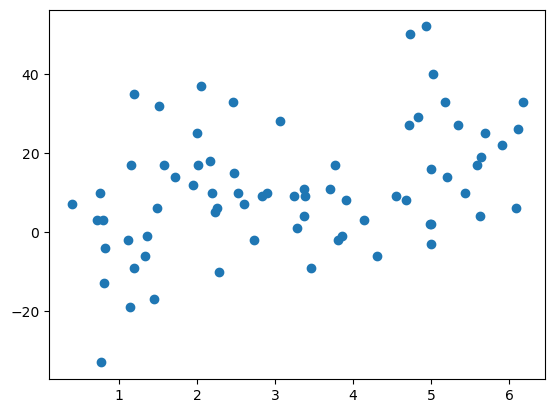

In [16]:
plt.scatter(x=celtics['test_var'],y=celtics['Diff_Points'])

In [17]:
celtics = celtics.drop(columns = 'test_var')

# Machine Learning

In [18]:
after_variables = ['Win','Celtics_Points','Opp_Points','Diff_Points','Total_Points']
bad_variables = ['Date','Opponent']
betting_variables = ['Over_Under','Celtics_Spread_Diff','Celtics_Spread_Payout','Opp_Spread_Diff','Opp_Spread_Payout']

cant_use = after_variables + bad_variables + betting_variables

celtics.head(5)

,Date,Opponent,Home_Away,In_Season_Tournament,Celtics_Win_Pct,Celtics_Home_Win_Pct,Celtics_Away_Win_Pct,Celtics_Win_Pct_Last_5_Games,Celtics_Win_Pct_Last_10_Games,Celtics_Avg_Points_Per_Game,Celtics_Avg_Points_Last_5_Games,Celtics_Avg_Points_Last_10_Games,Celtics_Avg_Off_Rating,Celtics_Avg_Off_Rating_Last_10_Games,Celtics_Avg_Def_Rating,Celtics_Avg_Def_Rating_Last_10_Games,Celtics_Avg_FG_Last_10_Games,Celtics_Avg_FG_Pct_Last_10_Games,Celtics_Avg_3P_Last_10_Games,Celtics_Avg_3P_Pct_Last_10_Games,Celtics_Avg_FT_Last_10_Games,Celtics_Avg_FT_Pct_Last_10_Games,Celtics_Rank_In_Conference,Celtics_Rank_In_Division,Celtics_Strength_Of_Key_Players_Missing,Opp_Win_Pct,Opp_Points_Last_Game,Opp_Win_Last_Game,Opp_FG_Last_Game,Opp_FG_Pct_Last_Game,Opp_3P_Last_Game,Opp_3P_Pct_Last_Game,Opp_FT_Last_Game,Opp_FT_Pct_Last_Game,Opp_Off_Rating_Last_Game,Opp_Def_Rating_Last_Game,Opp_Rank_In_Conference,Opp_Rank_In_Division,Opp_Strength_Of_Key_Players_Missing,Win,Celtics_Points,Opp_Points,Diff_Points,Total_Points,Over_Under,Celtics_Spread_Diff,Celtics_Spread_Payout,Opp_Spread_Diff,Opp_Spread_Payout
1,2023-10-25 00:00:00,New York Knicks,Away,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,True,108,104,4,212,223.0,-3.5,-112,3.5,-108
2,2023-10-27 00:00:00,Miami Heat,Home,False,1.0,NaN,1.0,NaN,NaN,108.000000,NaN,NaN,114.400000,NaN,110.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,1.000000,103.0,True,37.0,0.402,8.0,0.364,21.0,0.808,110.0,108.9,5.0,2.0,2,True,119,111,8,230,217.5,-8.5,-110,8.5,-110
3,2023-10-30 00:00:00,Washington Wizards,Away,False,1.0,1.0,1.0,NaN,NaN,113.500000,NaN,NaN,117.100000,NaN,110.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,0.500000,113.0,True,40.0,0.430,16.0,0.348,17.0,0.773,111.6,104.7,8.0,3.0,1,True,126,107,19,233,231.5,-10.5,-115,10.5,-105
4,2023-11-01 00:00:00,Indiana Pacers,Home,False,1.0,1.0,1.0,NaN,NaN,117.666667,NaN,NaN,119.333333,NaN,108.966667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,0.666667,105.0,False,36.0,0.409,12.0,0.261,21.0,0.840,100.0,103.5,2.0,1.0,4,True,155,104,51,259,233.5,-11.5,-110,11.5,-110
5,2023-11-04 00:00:00,Brooklyn Nets,Away,False,1.0,1.0,1.0,NaN,NaN,127.000000,NaN,NaN,126.575000,NaN,106.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2,0.600000,109.0,True,44.0,0.458,18.0,0.400,3.0,0.600,100.0,115.5,4.0,3.0,5,True,124,114,10,238,227.5,-9.5,-110,9.5,-110


## Custom Scoring

#### Learning how to make a scorer

In [19]:
def custom_easy_score(y, y_pred):
    return min(abs(y - y_pred).mean())

easy_scorer = make_scorer(custom_easy_score, greater_is_better=False)

#### Actual Scorer

In [20]:
def custom_profit_score(y, y_pred, celtics_line, celtics_payout, opp_payout, bet=None):
    if bet is None:
        bet = np.ones(len(y))

    if type(bet) in [int, float]:    
        bet = np.ones(len(y)) * bet
    
    bet_on_celtics = y_pred > (celtics_line * -1)
    celtics_win = y > (celtics_line * -1)
    opponent_win = y < (celtics_line * -1)

    payout = ((bet_on_celtics == celtics_win) * (((100/(celtics_payout*-1))*bet*(bet_on_celtics))+((100/(opp_payout*-1))*bet*(1-bet_on_celtics)))) + ((bet_on_celtics == celtics_win) * bet)

    return(sum(payout) - sum(bet))

In [21]:
profit_scorer = make_scorer(custom_profit_score)

#### Testing Scorer

In [22]:
y_fake = np.array([10,4,10,4])
y_pred_fake = np.array([8,8,2,2])
celtics_line_fake = np.array([-6.5,-6.5,-6.5,-6.5])
celtics_payout_fake = np.array([-110,-110,-110,-110])
opp_payout_fake = np.array([-110,-110,-110,-110])
bet_fake = 100

# data = {
#     'y_fake': y_fake,
#     'celtics_line_fake': celtics_line_fake,
#     'celtics_payout_fake': celtics_payout_fake,
#     'opp_payout_fake': opp_payout_fake
# }

# df_fake = pd.DataFrame(data)
# y_fak = df_fake['y_fake']
# celtics_line_fak = df_fake['celtics_line_fake']
# celtics_payout_fak = df_fake['celtics_payout_fake']
# opp_payout_fak = df_fake['opp_payout_fake']

custom_profit_score(y = y_fake,
                    y_pred = y_pred_fake,
                    celtics_line = celtics_line_fake,
                    celtics_payout = celtics_payout_fake,
                    opp_payout = opp_payout_fake,
                    bet = bet_fake)

-18.181818181818187

## Splitting

In [23]:
# the month of april is not a good representation of the season
# the first 10 games are drop for cumulative reasons
celtics = celtics.drop(index=celtics.tail(8).index)
celtics = celtics.drop(index=celtics.head(10).index)

In [24]:
# train on the whole season up to march
X_train = celtics.drop(columns = [col for col in after_variables])
X_train = X_train.drop(index=X_train.tail(16).index)
X_train = X_train.reset_index().drop(columns='index')
# X_train
# 48 rows

In [25]:
# predict the month of march
X_test = celtics.drop(columns = [col for col in after_variables])
X_test = X_test.tail(16)
# X_test
# 16 rows

In [26]:
y_train = celtics['Diff_Points']
y_train = y_train.drop(index=celtics.tail(16).index)
# y_train

In [27]:
y_test = celtics['Diff_Points']
y_test = y_test.tail(16)
# y_test

## CV Fold

#### Creating a custom fold

In [28]:
cv_custom = [
    (list(range(0,10,1)),list(range(10,15,1))),
    (list(range(0,15,1)),list(range(15,20,1))),
    (list(range(0,20,1)),list(range(20,25,1))),
    (list(range(5,25,1)),list(range(25,30,1))),
    (list(range(10,30,1)),list(range(30,35,1))),
    (list(range(15,35,1)),list(range(35,40,1))),
    (list(range(20,40,1)),list(range(40,45,1))),
    (list(range(25,45,1)),list(range(45,50,1))),
    (list(range(30,50,1)),list(range(50,55,1))),
    (list(range(33,53,1)),list(range(53,58,1))),
            ]
# cv_custom
# len(cv_custom)
# 10 folds

#### Built in time series split for fold

In [29]:
cv_time = TimeSeriesSplit(n_splits=10)

#### Uncomment to visualize this fold

In [30]:
# for i, (train_index, test_index) in enumerate(cv_time.split(X_train)):
#      print(f"Fold {i}:")
#      print(f"  Train: index={train_index}")
#      print(f"  Test:  index={test_index}")

## Preprocessing

In [31]:
# celtics.info()

In [32]:
# numerical and categorical pipelines
numer_pipe = Pipeline(
    [
        ("imputer",SimpleImputer(strategy='median')),
        ("scaler",StandardScaler()),
        ("feature_creation",'passthrough')
    ])

cat_pipe = Pipeline(
    [
        ("encoder",OneHotEncoder())
    ])

# numerical and categorical variables to use
numer_variables = celtics.select_dtypes(include='number').columns
numer_variables = [var for var in numer_variables if var not in cant_use]

cat_variables = ['In_Season_Tournament','Opp_Win_Last_Game']

# preprocessing pipeline
preproc_pipe = ColumnTransformer(
    [
        ("numer",numer_pipe,numer_variables),
        ("cat",cat_pipe,cat_variables)
    ],
        remainder='drop')

# preprocessing dataframe
preproc_df = df_after_transform(preproc_pipe,X_train)
print(f"There are {preproc_df.shape[1]} columns in the preprocessed dataframe")
# preproc_df.describe().T.round(2)
# preproc_df

There are 38 columns in the preprocessed dataframe


## Custom Cross Validation

In [33]:
def perform_cross_validation(model, X, y, cv, line, celtics_payout, opp_payout, bet_size):
    scores=[]
    for train_index, test_index in cv.split(X):
        X_training, X_testing = X.iloc[train_index], X.iloc[test_index]
        y_training, y_testing = y.iloc[train_index], y.iloc[test_index]
        line_test = line.iloc[test_index]
        celtics_payout_test =  celtics_payout.iloc[test_index]
        opp_payout_test =  opp_payout.iloc[test_index]

        model_clone = clone(model)
        ypred = model_clone.fit(X_training, y_training).predict(X_testing)
        score = custom_profit_score(y=y_testing.values, 
                                    y_pred=ypred,
                                    celtics_line=line_test.values,
                                    celtics_payout=celtics_payout_test.values,
                                    opp_payout=opp_payout_test.values,
                                    bet=bet_size)
        scores.append(score)
    return {'scores': scores}

## Custom Grid Search

In [34]:
def grid_search_custom_cv(model, param_grid, X, y, line, celtics_payout, opp_payout, cv, bet_size):
    results = []
   
    for params in ParameterGrid(param_grid):
        model_clone = clone(model)
        model_clone.set_params(**params)
       
        cv_results = perform_cross_validation(model_clone, X, y, cv, line, celtics_payout, opp_payout, bet_size)
        results.append({
            **params,
            'scores': cv_results['scores'],
            'mean_score': np.mean(cv_results['scores']),
            'std_score': np.std(cv_results['scores'])
        })
   
    return pd.DataFrame(results)

## Testing Models

In [35]:
bet_amount = 100

### Model 1

In [36]:
pipe = Pipeline(
    [
        ('preproc',preproc_pipe),
        ('feature_select','passthrough'),
        ('clf',Lasso(alpha=1))
    ])
# pipe

In [37]:
results = grid_search_custom_cv(model=pipe,
                      param_grid={'clf__alpha': [a for a in np.linspace(0.001,1,20)]},
                      X = X_train,
                      y = y_train,
                      line = X_train['Celtics_Spread_Diff'],
                      celtics_payout = X_train['Celtics_Spread_Payout'],
                      opp_payout = X_train['Opp_Spread_Payout'],
                      cv = cv_time,
                      bet_size=bet_amount)
# results

In [38]:
best_index = results['mean_score'].idxmax()
results.iloc[best_index].to_frame().T

,clf__alpha,scores,mean_score,std_score
1,0.053579,"[-209.0909090909091, -18.181818181818187, -18.181818181818187, -209.0909090909091, -209.0909090909091, -209.0909090909091, -18.181818181818187, 172.72727272727275, -209.0909090909091, -209.0909090909091]",-113.636364,128.065711


In [39]:
best_pipe = Pipeline(
    [
        ('preproc',preproc_pipe),
        ('feature_select','passthrough'),
        ('clf',Lasso(alpha=0.053579))
    ])
# best_pipe

In [40]:
best_pipe.fit(X_train,y_train)

coef_df = pd.DataFrame({'colname' : preproc_df.columns,
                        'coef' : best_pipe['clf'].coef_ })\
            .query('abs(coef) > 0.0001')\
            .sort_values('coef').reset_index().drop('index',axis=1)

print(f'''
Lasso kept {sum(best_pipe['clf'].coef_ != 0)} important features
and dropped the other {sum(best_pipe['clf'].coef_ == 0)} features
''')


Lasso kept 30 important features
and dropped the other 8 features



In [41]:
coef_df

,colname,coef
0,Celtics_Avg_Points_Last_5_Games,-18.073756
1,Celtics_Avg_FG_Pct_Last_10_Games,-16.355915
2,Celtics_Avg_FT_Last_10_Games,-15.877720
3,Celtics_Avg_FG_Last_10_Games,-13.298632
4,Celtics_Avg_3P_Last_10_Games,-12.097228
5,Celtics_Win_Pct,-10.123064
6,Celtics_Away_Win_Pct,-10.104183
7,Opp_Rank_In_Division,-5.918623
8,Opp_FG_Last_Game,-5.366658
9,Opp_Off_Rating_Last_Game,-4.691824


In [42]:
y_pred = best_pipe.fit(X_train,y_train).predict(X_test)
custom_profit_score(y_test,y_pred,X_test['Celtics_Spread_Diff'],X_test['Celtics_Spread_Payout'],X_test['Opp_Spread_Payout'],bet_amount)

309.09090909090946

### ???????? ^^^^^

In [43]:
def make_payout_df(y,y_pred,celtics_line,celtics_payout,opp_payout,bet):
    
    df = pd.DataFrame({
    'y_test': y.values,
    'y_pred': y_pred,
    'celtics_line': celtics_line.values,
    'celtics_payout': celtics_payout.values,
    'opp_payout': opp_payout.values,
    'bet': np.ones(len(y_test)) * bet
})
    df['bet_on_celtics'] = (df['y_pred'] > (-df['celtics_line'])).astype(int)
    df['celtics_win'] = (df['y_test'] > (-df['celtics_line'])).astype(int)
    df['opp_win'] = (df['y_test'] < (-df['celtics_line'])).astype(int)
    df['payout'] = ((df['bet_on_celtics'] == df['celtics_win']) * (((100/(df['celtics_payout']*-1))*df['bet']*(df['bet_on_celtics']))+((100/(df['opp_payout']*-1))*df['bet']*(1-df['bet_on_celtics'])))) + ((df['bet_on_celtics'] == df['celtics_win']) * df['bet'])
    return df

In [44]:
make_payout_df(y=y_test,
               y_pred=y_pred,
               celtics_line=X_test['Celtics_Spread_Diff'],
               celtics_payout=X_test['Celtics_Spread_Payout'],
               opp_payout=X_test['Opp_Spread_Payout'],
               bet=bet_amount)

,y_test,y_pred,celtics_line,celtics_payout,opp_payout,bet,bet_on_celtics,celtics_win,opp_win,payout
0,28,4.421642,-8.5,-110,-110,100.0,0,1,0,0.000000
1,52,-5.056246,-7.5,-110,-110,100.0,0,1,0,0.000000
2,-1,-24.308127,-8.5,-110,-110,100.0,0,0,1,190.909091
3,-6,-21.520836,-2.5,-110,-110,100.0,0,0,1,190.909091
4,10,-3.562045,-5.5,-110,-110,100.0,0,1,0,0.000000
5,22,-19.371579,-11.5,-110,-110,100.0,0,1,0,0.000000
6,16,16.448712,-6.5,-110,-110,100.0,1,1,0,190.909091
7,15,26.960147,-5.5,-110,-110,100.0,1,1,0,190.909091
8,26,67.415050,-14.5,-110,-110,100.0,1,1,0,190.909091
9,25,41.392881,-15.5,-110,-110,100.0,1,1,0,190.909091


### Model 2

In [45]:
# numerical and categorical pipelines
numer_pipe = Pipeline(
    [
        ("imputer",SimpleImputer(strategy='median')),
        ("scaler",StandardScaler()),
        ("feature_creation",PolynomialFeatures(degree=2))
    ])

cat_pipe = Pipeline(
    [
        ("encoder",OneHotEncoder())
    ])

# numerical and categorical variables to use
numer_variables = celtics.select_dtypes(include='number').columns
numer_variables = [var for var in numer_variables if var not in cant_use]

cat_variables = ['In_Season_Tournament','Opp_Win_Last_Game']

# preprocessing pipeline
preproc_pipe = ColumnTransformer(
    [
        ("numer",numer_pipe,numer_variables),
        ("cat",cat_pipe,cat_variables)
    ],
        remainder='drop')

# preprocessing dataframe
preproc_df = df_after_transform(preproc_pipe,X_train)
print(f"There are {preproc_df.shape[1]} columns in the preprocessed dataframe")
# preproc_df.describe().T.round(2)
# preproc_df

There are 634 columns in the preprocessed dataframe


In [46]:
pipe = Pipeline(
    [
        ('preproc',preproc_pipe),
        ('feature_select','passthrough'),
        ('clf',Lasso(alpha=1))
    ])
# pipe

In [47]:
results = grid_search_custom_cv(model=pipe,
                      param_grid={'clf__alpha': [a for a in np.linspace(0.001,1,20)]},
                      X = X_train,
                      y = y_train,
                      line = X_train['Celtics_Spread_Diff'],
                      celtics_payout = X_train['Celtics_Spread_Payout'],
                      opp_payout = X_train['Opp_Spread_Payout'],
                      cv = cv_time,
                      bet_size=bet_amount)
# results

In [48]:
best_index = results['mean_score'].idxmax()
results.iloc[best_index].to_frame().T

,clf__alpha,scores,mean_score,std_score
19,1.0,"[177.05627705627705, 172.72727272727275, 363.6363636363636, -209.0909090909091, -18.181818181818187, -209.0909090909091, 172.72727272727275, 172.72727272727275, 172.72727272727275, 363.6363636363636]",115.887446,191.994836


In [49]:
best_pipe = Pipeline(
    [
        ('preproc',preproc_pipe),
        ('feature_select','passthrough'),
        ('clf',Lasso(alpha=1))
    ])
# best_pipe

In [50]:
best_pipe.fit(X_train,y_train)

coef_df = pd.DataFrame({'colname' : preproc_df.columns,
                        'coef' : best_pipe['clf'].coef_ })\
            .query('abs(coef) > 0.0001')\
            .sort_values('coef').reset_index().drop('index',axis=1)

print(f'''
Lasso kept {sum(best_pipe['clf'].coef_ != 0)} important features
and dropped the other {sum(best_pipe['clf'].coef_ == 0)} features
''')


Lasso kept 35 important features
and dropped the other 599 features



In [51]:
y_pred = best_pipe.fit(X_train,y_train).predict(X_test)
custom_profit_score(y_test,y_pred,X_test['Celtics_Spread_Diff'],X_test['Celtics_Spread_Payout'],X_test['Opp_Spread_Payout'],bet_amount)

-836.3636363636364

In [52]:
make_payout_df(y=y_test,
               y_pred=y_pred,
               celtics_line=X_test['Celtics_Spread_Diff'],
               celtics_payout=X_test['Celtics_Spread_Payout'],
               opp_payout=X_test['Opp_Spread_Payout'],
               bet=bet_amount)

,y_test,y_pred,celtics_line,celtics_payout,opp_payout,bet,bet_on_celtics,celtics_win,opp_win,payout
0,28,8.083891,-8.5,-110,-110,100.0,0,1,0,0.000000
1,52,12.143246,-7.5,-110,-110,100.0,1,1,0,190.909091
2,-1,32.169300,-8.5,-110,-110,100.0,1,0,1,0.000000
3,-6,8.286247,-2.5,-110,-110,100.0,1,0,1,0.000000
4,10,3.240847,-5.5,-110,-110,100.0,0,1,0,0.000000
5,22,9.998957,-11.5,-110,-110,100.0,0,1,0,0.000000
6,16,0.549139,-6.5,-110,-110,100.0,0,1,0,0.000000
7,15,3.437969,-5.5,-110,-110,100.0,0,1,0,0.000000
8,26,21.792095,-14.5,-110,-110,100.0,1,1,0,190.909091
9,25,18.000477,-15.5,-110,-110,100.0,1,1,0,190.909091


### Model 3

In [53]:
# numerical and categorical pipelines
numer_pipe = Pipeline(
    [
        ("imputer",SimpleImputer(strategy='median')),
        ("scaler",StandardScaler()),
        ("feature_creation",PolynomialFeatures(degree=1))
    ])

cat_pipe = Pipeline(
    [
        ("encoder",OneHotEncoder())
    ])

# numerical and categorical variables to use
numer_variables = celtics.select_dtypes(include='number').columns
numer_variables = [var for var in numer_variables if var not in cant_use]

cat_variables = ['In_Season_Tournament','Opp_Win_Last_Game']

# preprocessing pipeline
preproc_pipe = ColumnTransformer(
    [
        ("numer",numer_pipe,numer_variables),
        ("cat",cat_pipe,cat_variables)
    ],
        remainder='drop')

# preprocessing dataframe
preproc_df = df_after_transform(preproc_pipe,X_train)
print(f"There are {preproc_df.shape[1]} columns in the preprocessed dataframe")
# preproc_df.describe().T.round(2)
# preproc_df

There are 39 columns in the preprocessed dataframe


In [54]:
pipe = Pipeline(
    [
        ('preproc',preproc_pipe),
        ('feature_select',SelectKBest()),
        ('clf',Ridge())
    ])
# pipe

In [55]:
# pipe.get_params()

In [56]:
results = grid_search_custom_cv(model=pipe,
                      param_grid={'clf__alpha': [a for a in np.logspace(-3,3,8)],
                                 'feature_select__k': [5,6,7,8,9,10]},
                      X = X_train,
                      y = y_train,
                      line = X_train['Celtics_Spread_Diff'],
                      celtics_payout = X_train['Celtics_Spread_Payout'],
                      opp_payout = X_train['Opp_Spread_Payout'],
                      cv = cv_time,
                      bet_size=bet_amount)
# results

In [57]:
best_index = results['mean_score'].idxmax()
results.iloc[best_index].to_frame().T

,clf__alpha,feature_select__k,scores,mean_score,std_score
26,2.682696,7,"[177.05627705627705, -209.0909090909091, 363.6363636363636, -209.0909090909091, -209.0909090909091, 172.72727272727275, -18.181818181818187, -209.0909090909091, -209.0909090909091, 172.72727272727275]",-17.748918,209.529265


In [58]:
best_pipe = Pipeline(
    [
        ('preproc',preproc_pipe),
        ('feature_select',SelectKBest(k=8)),
        ('clf',Ridge(alpha=2.682696))
    ])
# best_pipe

In [59]:
y_pred = best_pipe.fit(X_train,y_train).predict(X_test)
custom_profit_score(y_test,y_pred,X_test['Celtics_Spread_Diff'],X_test['Celtics_Spread_Payout'],X_test['Opp_Spread_Payout'],bet_amount)

500.00000000000045

In [60]:
make_payout_df(y=y_test,
               y_pred=y_pred,
               celtics_line=X_test['Celtics_Spread_Diff'],
               celtics_payout=X_test['Celtics_Spread_Payout'],
               opp_payout=X_test['Opp_Spread_Payout'],
               bet=bet_amount)

,y_test,y_pred,celtics_line,celtics_payout,opp_payout,bet,bet_on_celtics,celtics_win,opp_win,payout
0,28,8.374595,-8.5,-110,-110,100.0,0,1,0,0.000000
1,52,9.803109,-7.5,-110,-110,100.0,1,1,0,190.909091
2,-1,14.476418,-8.5,-110,-110,100.0,1,0,1,0.000000
3,-6,17.763165,-2.5,-110,-110,100.0,1,0,1,0.000000
4,10,16.459110,-5.5,-110,-110,100.0,1,1,0,190.909091
5,22,16.541414,-11.5,-110,-110,100.0,1,1,0,190.909091
6,16,17.928527,-6.5,-110,-110,100.0,1,1,0,190.909091
7,15,13.871022,-5.5,-110,-110,100.0,1,1,0,190.909091
8,26,24.852029,-14.5,-110,-110,100.0,1,1,0,190.909091
9,25,18.380678,-15.5,-110,-110,100.0,1,1,0,190.909091


### Model 4

In [61]:
pipe = Pipeline(
    [
        ('preproc',preproc_pipe),
        ('feature_select',SequentialFeatureSelector(LinearRegression())),
        ('clf',LinearRegression())
    ])
# pipe

In [62]:
# pipe.get_params()

In [63]:
results = grid_search_custom_cv(model=pipe,
                      param_grid={'feature_select__n_features_to_select': [10,15,20,25]},
                      X = X_train,
                      y = y_train,
                      line = X_train['Celtics_Spread_Diff'],
                      celtics_payout = X_train['Celtics_Spread_Payout'],
                      opp_payout = X_train['Opp_Spread_Payout'],
                      cv = cv_time,
                      bet_size=bet_amount)
results

,feature_select__n_features_to_select,scores,mean_score,std_score
0,10,"[-13.852813852813824, -209.0909090909091, 172.72727272727275, -18.181818181818187, -209.0909090909091, -209.0909090909091, -209.0909090909091, 172.72727272727275, -400.0, -400.0]",-132.294372,194.948692
1,15,"[-13.852813852813824, -209.0909090909091, 172.72727272727275, 172.72727272727275, -209.0909090909091, -209.0909090909091, -18.181818181818187, 172.72727272727275, -400.0, -400.0]",-94.112554,212.746776
2,20,"[177.05627705627705, -209.0909090909091, -209.0909090909091, -18.181818181818187, -209.0909090909091, -209.0909090909091, -209.0909090909091, -18.181818181818187, -400.0, -400.0]",-170.476190,167.327167
3,25,"[177.05627705627705, -18.181818181818187, -209.0909090909091, -18.181818181818187, -18.181818181818187, -209.0909090909091, -209.0909090909091, 172.72727272727275, -209.0909090909091, -209.0909090909091]",-75.021645,149.829216


In [64]:
best_index = results['mean_score'].idxmax()
results.iloc[best_index].to_frame().T

,feature_select__n_features_to_select,scores,mean_score,std_score
3,25,"[177.05627705627705, -18.181818181818187, -209.0909090909091, -18.181818181818187, -18.181818181818187, -209.0909090909091, -209.0909090909091, 172.72727272727275, -209.0909090909091, -209.0909090909091]",-75.021645,149.829216


In [65]:
best_pipe = Pipeline(
    [
        ('preproc',preproc_pipe),
        ('feature_select',SequentialFeatureSelector(LinearRegression(),n_features_to_select=25)),
        ('clf',LinearRegression())
    ])
# best_pipe

In [66]:
y_pred = best_pipe.fit(X_train,y_train).predict(X_test)
custom_profit_score(y_test,y_pred,X_test['Celtics_Spread_Diff'],X_test['Celtics_Spread_Payout'],X_test['Opp_Spread_Payout'],bet_amount)

-72.72727272727252

In [67]:
make_payout_df(y=y_test,
               y_pred=y_pred,
               celtics_line=X_test['Celtics_Spread_Diff'],
               celtics_payout=X_test['Celtics_Spread_Payout'],
               opp_payout=X_test['Opp_Spread_Payout'],
               bet=bet_amount)

,y_test,y_pred,celtics_line,celtics_payout,opp_payout,bet,bet_on_celtics,celtics_win,opp_win,payout
0,28,-14.632646,-8.5,-110,-110,100.0,0,1,0,0.000000
1,52,-11.679664,-7.5,-110,-110,100.0,0,1,0,0.000000
2,-1,24.342374,-8.5,-110,-110,100.0,1,0,1,0.000000
3,-6,24.233088,-2.5,-110,-110,100.0,1,0,1,0.000000
4,10,7.636149,-5.5,-110,-110,100.0,1,1,0,190.909091
5,22,11.153608,-11.5,-110,-110,100.0,0,1,0,0.000000
6,16,24.007052,-6.5,-110,-110,100.0,1,1,0,190.909091
7,15,31.316023,-5.5,-110,-110,100.0,1,1,0,190.909091
8,26,52.553428,-14.5,-110,-110,100.0,1,1,0,190.909091
9,25,31.447832,-15.5,-110,-110,100.0,1,1,0,190.909091
